## Predicting West Nile Virus Presence in Mosquito Traps (Kaggle Competition)

The following was a group project, completed with the help of two of my colleagues, to analyze and predict the presence of West Nile Virus (WNV) in mosquito traps in the Chicago, Illinois region. This project originated as a Kaggle competition, with teams being provided several data files from which to draw inferences and make predictions about the presence of WNV.

Two files (train and test) contained data on mosquito traps around the Chicago area. The train file comprised data from 2007, 2009, 2011, and 2013 describing traps containing mosquitos, which included (among other variables) location of the trap, the species of mosquitos detected, the number of mosquitos counted, and whether WNV was detected within the mosquitos detected. The test file, by contrast, asked teams to predict the presence of WNV for the years 2008, 2010, 2012, and 2014, given hypothetical information about each trap for specific observational days. That is, provided information about specific trap locations on specific days containing specific species of mosquitos, what is the probability that the trap contains WNV?

Another file provided weather data for the Chicago area from 2007 to 2014, as collected from two separate airport weather stations (O'Hare and Midway).

A final file provided spray data describing times and locations of pesticide spraying in the Chicago area for the years 2011 and 2013.

The dataset, along with a more thorough description, can be found here: https://www.kaggle.com/c/predict-west-nile-virus/

### Summary and Analysis:
Exploring the initial training data included examining relationships between "primary" traps and related "satellite" traps that were in close proximity. Initial EDA also examined the consistency of trap locations across all years of the data.  While there were a few discrepencies discovered (e.g., two traps had more than one set of latitude and longitude coordinates across all years), the number of observations affected by these discrepencies were quite few and far between. 

In the initial training data, if more than 50 mosquitos of a specific species were found in a given trap on a given day, new observations were generated for each set of 50 mosquitos trapped, with a final observation containing any remainder. In the process of examining the data, we collapsed all rows of specific species for each trap on each day to more properly reflect the number of mosquitos actually observed, and to more accurately reflect the true number of WNV detections in the training data.  That is, if more than 50 mosquitos were found in a trap with WNV, there could potentially be more than one observation of WNV detected, whereas counting all of the mosquitos together would only produce a single observation of WNV.  

To predict WNV presence in the test set, we engineered several features in an attempt to capture probability of WNV given specifics on the traps and mosquito species being observed. These included the number of years in the train data for which each trap contained WNV at any point, the maximum number of times in a single train year each trap contained WNV, 	the total number of times each trap contained WNV in the train data, the proportion of observations for each trap in which WNV was detected, the proportion of observations for each mosquito species in which WNV was detected, and the proportion of observations for each species in each trap for which WNV was detected. These "risk assessment" variables were then applied to each trap and species where appropriate in the test data to approximate the relative likelihoods that any given observation might result in detection of WNV. Where specific traps existed in the test data that were not included in the train data, values were imputed based on the test traps' proximity to traps seen in the train set.

We also utilized several weather variables to predict the presence of WNV in the test data, including average temperature, total precipitation, air pressure, a 7-day rolling average of precipitation, and whether or not wind speed was 1 standard deviation above the mean. 

In developing our final model, we decided to more forward with a Bagged Gradient Boosting Classifier. 
The predicted accuracy of a bagged gradient boosting classifier was effectively the same as the standard 
GBC, and we felt as though the bagging process had the potential correct for some inherent error in the singular GBC
by creating an ensemble model.

Submitting initial findings to Kaggle site resulted in a score of 0.66207 area under ROC curve.

### Improvements to be considered for future work
In terms of additional variables that could have assisted with our analyses, in retrospect, we should have more closely examined the most prominent months for WNV outbreaks. WNV outbreaks were most frequent in the month of August, and including a simply binary variables for "Is_August" might have provided more predictive power.  In addition, generating rolling average variables that take a wider assessment of heat and precipitation over the lifespan of a mosquito (e.g., several weeks rather than just a few days) might also have improved the general predictive power of our modeling. 

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor, BaggingRegressor, BaggingClassifier, AdaBoostClassifier


# display plots in the notebook
%matplotlib inline
# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['font.size'] = 12

### Examining and Preparing Train Data

In [128]:
#reading in train data file:
train = pd.read_csv("train.csv")
train.head()

# Notes on Data From Kaggle:
# Every year from late-May to early-October, public health workers in Chicago setup mosquito traps scattered across 
# the city. Every week from Monday through Wednesday, these traps collect mosquitos, and the mosquitos are tested for 
# the presence of West Nile virus before the end of the week. The test results include the number of mosquitos, 
# the mosquitos species, and whether or not West Nile virus is present in the cohort. 

# These test results are organized in such a way that when the number of mosquitos exceed 50, they are split into 
# another record (another row in the dataset), such that the number of mosquitos are capped at 50. 

# The location of the traps are described by the block number and street name. For your convenience, we have mapped 
# these attributes into Longitude and Latitude in the dataset. Please note that these are derived locations. 
# For example, Block=79, and Street= "W FOSTER AVE" gives us an approximate address of "7900 W FOSTER AVE, Chicago, IL",
# which translates to (41.974089,-87.824812) on the map.

# Some traps are "satellite traps". These are traps that are set up near (usually within 6 blocks) an established trap 
# to enhance surveillance efforts. Satellite traps are postfixed with letters. For example, T220A is a satellite trap 
# to T220 

# Please note that not all the locations are tested at all times. Also, records exist only when a particular species 
# of mosquitos is found at a certain trap at a certain time. In the test set, we ask you for all combinations / 
# permutations of possible predictions and are only scoring the observed ones.

# train.csv, test.csv - the training and test set of the main dataset. The training set consists of data from 
# 2007, 2009, 2011, and 2013, while in the test set you are requested to predict the test results for 2008, 2010, 2012, 
# and 2014.
# Id: the id of the record
# Date: date that the WNV test is performed
# Address: approximate address of the location of trap. This is used to send to the GeoCoder. 
# Species: the species of mosquitos
# Block: block number of address
# Street: street name
# Trap: Id of the trap
# AddressNumberAndStreet: approximate address returned from GeoCoder
# Latitude, Longitude: Latitude and Longitude returned from GeoCoder
# AddressAccuracy: accuracy returned from GeoCoder
# NumMosquitos: number of mosquitoes caught in this trap
# WnvPresent: whether West Nile Virus was present in these mosquitos. 1 means WNV is present, and 0 means not present. 

#WnvPresent is clearly the target variable here. 
#will need to convert date column to date_time

#Can tell that trap observations are split according to species detected (separate obs for each species detected)


,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [129]:
#Basic EDA checks:
train.describe(include="all")

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
count,10506,10506,10506,10506.000000,10506,10506,10506,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000
unique,95,138,7,NaN,128,136,138,NaN,NaN,NaN,NaN,NaN
top,2007-08-01,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS/RESTUANS,NaN,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",NaN,NaN,NaN,NaN,NaN
freq,551,750,4752,NaN,750,750,750,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,35.687797,NaN,NaN,NaN,41.841139,-87.699908,7.819532,12.853512,0.052446
std,NaN,NaN,NaN,24.339468,NaN,NaN,NaN,0.112742,0.096514,1.452921,16.133816,0.222936
min,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,41.644612,-87.930995,3.000000,1.000000,0.000000
25%,NaN,NaN,NaN,12.000000,NaN,NaN,NaN,41.732984,-87.760070,8.000000,2.000000,0.000000
50%,NaN,NaN,NaN,33.000000,NaN,NaN,NaN,41.846283,-87.694991,8.000000,5.000000,0.000000
75%,NaN,NaN,NaN,52.000000,NaN,NaN,NaN,41.954690,-87.627796,9.000000,17.000000,0.000000


In [130]:
train.isnull().sum()
#no null values to worry about.

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

In [131]:
#converting Date to datatime format
train["Date"] = pd.to_datetime(train["Date"], infer_datetime_format=True)

#Creating a separate column for "year" for ease of reading and later filtering
train["Year"] = train["Date"].dt.year

#Creating "Parent Trap" column that will indicate all traps associated with a parent trap (e.g., T002A would be T002)
train["Parent_Trap"] = train["Trap"].str[:4]

#creating column to indicate if trap is satellite (1) or not (0) 
train["Is_Satellite"] = 1.0
#If Parent Trap == Trap, mark as not sattelite
train.ix[train["Trap"] == train["Parent_Trap"], "Is_Satellite"] = 0.0

train.groupby("Is_Satellite").Is_Satellite.count()
#there are barely any records of satellite traps - only 14 in the entire dataset
#After examining the data, there are only two satellite traps in the train set - T054C and T094B


Is_Satellite
0.0    10492
1.0       14
Name: Is_Satellite, dtype: int64

In [132]:
#For ease of data use, dropping Address, Block, Street, AddressNumberAndStreet, AddressAccuracy from Train - 
#we decided not to utilize these variables, as latitude and longitude appear to be just as informative in fewer variables
train.drop(["Address", "Block", "Street", "AddressNumberAndStreet", "AddressAccuracy"], axis=1, inplace=True)
train.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Year,Parent_Trap,Is_Satellite
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,2007,T002,0.0
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0,2007,T002,0.0
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0,2007,T007,0.0
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0,2007,T015,0.0
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,4,0,2007,T015,0.0


In [133]:
#Finding which traps are associated with more than one pair of latitude and longitude:
dup_lat = train.groupby(["Trap", "Longitude"]).Latitude.count().unstack()

#filling in NaN values with 0
dup_lat.fillna(value=0.0, inplace=True) 

#counting number of non-zero cells in each row, and generating a separate column of these counts:
#sourced from https://stackoverflow.com/questions/29229600/counting-number-of-zeros-per-row-by-pandas-dataframe
dup_lat["distinct"] = (dup_lat != 0).sum(axis=1)

#filtering to show only rows where more than one latitude is recorded for any trap
dup_lat = dup_lat[dup_lat["distinct"] > 1]

#removing all columns with all zeros to better see values of coordinate pairs:
#sourced from https://stackoverflow.com/questions/21164910/delete-column-in-pandas-based-on-condition
dup_lat = dup_lat.loc[:, (dup_lat != 0).any(axis=0)]

print("Traps with more than one pair of associated Lat/Long coordinates: ")
print
print(dup_lat)
print
#two traps (T009 and T035) are associated with more than one pair of long/lat coordinates - perhaps they were replaced
#in different years? Also confirmed that grouping by Trap and Latitude and counting Longitude produced the same 
#results.

#Checking years for which the two multi-coordinate traps had each pair of coordinates
print("Longitude Coordinates of Trap T009 by Year: ")
print(train[train.Trap == "T009"].groupby("Year").Longitude.value_counts())
print
print("Longitude Coordinates of Trap T035 by Year: ")
print(train[train.Trap == "T035"].groupby("Year").Longitude.value_counts())

#It looks like both traps had different coordinates in 2007 than in 2009 (at least for T009), 2011, and 2013. We'll
#have to look at the test data to see when these traps had different coordinates. (likely either 2008 or 2009.)

Traps with more than one pair of associated Lat/Long coordinates: 

Longitude  -87.862995  -87.812827  -87.742302  -87.677737  distinct
Trap                                                               
T009             80.0        31.0         0.0         0.0         2
T035              0.0         0.0        45.0        27.0         2

Longitude Coordinates of Trap T009 by Year: 
Year  Longitude 
2007  -87.812827    31
2009  -87.862995    27
2011  -87.862995    12
2013  -87.862995    41
Name: Longitude, dtype: int64

Longitude Coordinates of Trap T035 by Year: 
Year  Longitude 
2007  -87.677737    27
2011  -87.742302    18
2013  -87.742302    27
Name: Longitude, dtype: int64


In [134]:
#finding all rows where Date, Species, and Trap are duplicates, so that the number of mosquitos for each unique
#combination can be summed together.

#Setting "keep=False" to ensure *all* duplicates are included (normally, the first unique instance is not included)
dup_trap_spec = train[train[["Date", "Species", "Trap"]].duplicated(keep=False)] 

dup_trap_spec.head(10)
#lots of duplicates here; different numbers of the same species of mosquitos in the same trap in the same day.
#I checked the dates, and there are many occurances
#of sequential test days (e.g., testing  '2007-08-01', '2007-08-02', and'2007-08-03'). We do not
#believe that tests are being conducted on the same trap multiple times per day.  We decided to add all mosquitos
#from all traps of the same species, trap, and date together (without deleting duplicate rows). We then ensured that 
#any row with WNV present translates to the combined also indicating WNV being present.

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Year,Parent_Trap,Is_Satellite
98,2007-06-26,CULEX PIPIENS/RESTUANS,T086,41.688324,-87.676709,1,0,2007,T086,0.0
99,2007-06-26,CULEX PIPIENS/RESTUANS,T086,41.688324,-87.676709,1,0,2007,T086,0.0
280,2007-07-11,CULEX RESTUANS,T015,41.974089,-87.824812,1,0,2007,T015,0.0
281,2007-07-11,CULEX RESTUANS,T015,41.974089,-87.824812,2,0,2007,T015,0.0
293,2007-07-11,CULEX PIPIENS/RESTUANS,T086,41.688324,-87.676709,50,0,2007,T086,0.0
294,2007-07-11,CULEX PIPIENS/RESTUANS,T086,41.688324,-87.676709,35,0,2007,T086,0.0
295,2007-07-11,CULEX PIPIENS/RESTUANS,T086,41.688324,-87.676709,50,0,2007,T086,0.0
296,2007-07-11,CULEX PIPIENS/RESTUANS,T086,41.688324,-87.676709,8,0,2007,T086,0.0
297,2007-07-11,CULEX RESTUANS,T086,41.688324,-87.676709,1,0,2007,T086,0.0
298,2007-07-11,CULEX RESTUANS,T086,41.688324,-87.676709,8,0,2007,T086,0.0


In [135]:
#to consolidate all rows, while summing NumMosquitos and WnvPresent, we'll need to use a grouby.sum expression.
#determining list of columns where info should be the same for every duplicate row.
mosnum_group_columns = list(dup_trap_spec.columns)
mosnum_group_columns.remove("NumMosquitos")
mosnum_group_columns.remove("WnvPresent")
print(mosnum_group_columns)

['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'Year', 'Parent_Trap', 'Is_Satellite']


In [136]:
#consolidating rows, summing NumMosquitos and WnvPresent values, using "as_index=False" to ensure all rows have 
#all appropriate values (e.g., not only having one instance of a date for all rows associated with that date)
consol_rows = pd.DataFrame(dup_trap_spec.groupby(mosnum_group_columns, as_index=False).sum())

#WnvPresent should only be 1 or 0, so any values of WnvPresent > 1.0 should be reset to 1.0
consol_rows.ix[consol_rows.WnvPresent > 1.0, "WnvPresent"] = 1.0

#ensuring only 0s and 1s for WnvPresent
print(consol_rows.WnvPresent.value_counts())

#rearranging columns in consol_rows to match order of train data
consol_rows = consol_rows[train.columns]

consol_rows.head()

0.0    608
1.0    147
Name: WnvPresent, dtype: int64


,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Year,Parent_Trap,Is_Satellite
0,2007-06-26,CULEX PIPIENS/RESTUANS,T086,41.688324,-87.676709,2,0.0,2007,T086,0.0
1,2007-07-11,CULEX PIPIENS/RESTUANS,T016,42.011601,-87.811506,51,0.0,2007,T016,0.0
2,2007-07-11,CULEX PIPIENS/RESTUANS,T086,41.688324,-87.676709,143,0.0,2007,T086,0.0
3,2007-07-11,CULEX PIPIENS/RESTUANS,T158,41.682587,-87.707973,189,0.0,2007,T158,0.0
4,2007-07-11,CULEX RESTUANS,T011,41.944869,-87.832763,3,0.0,2007,T011,0.0


In [137]:
#dropping all original rows in dup_trap_spec from train
train = train[~train.isin(dup_trap_spec)].dropna(how='all')

#concatenating consol_rows onto bottom of train.
train = pd.concat([train, consol_rows], axis=0)

#resorting train by Date, Trap, and Species, and resetting index.
train = train.sort_values(by=['Date', "Trap", "Species"])
train.reset_index(inplace=True, drop=True)

train.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Year,Parent_Trap,Is_Satellite
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1.0,0.0,2007.0,T002,0.0
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1.0,0.0,2007.0,T002,0.0
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1.0,0.0,2007.0,T007,0.0
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1.0,0.0,2007.0,T015,0.0
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,4.0,0.0,2007.0,T015,0.0


In [138]:
#separating out data of traps and dates for where WNV was present.
wnv_outbreaks = train[train["WnvPresent"] == 1].groupby("Date").WnvPresent.count()
#creating new dataframe from data, and generating a separate index column
wnv_outbreaks = pd.DataFrame(wnv_outbreaks)
wnv_outbreaks.reset_index(inplace=True)
wnv_outbreaks.head()

,Date,WnvPresent
0,2007-07-18,1
1,2007-07-25,2
2,2007-08-01,15
3,2007-08-02,3
4,2007-08-07,11


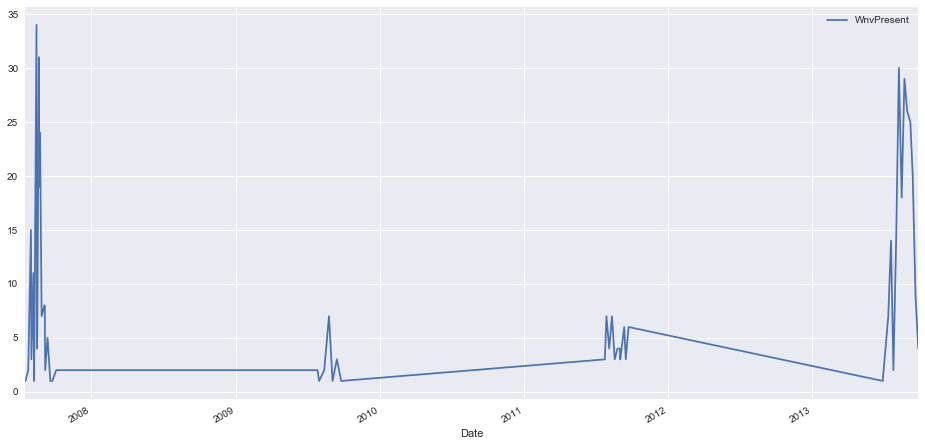

In [139]:
wnv_outbreaks.plot(x="Date", y="WnvPresent")

#definitely a lot fewer observations of wnv in 2009 and 2011 than in 2007 and 2013.  Take account of this when
#examining the y-axes of the following yearly plots

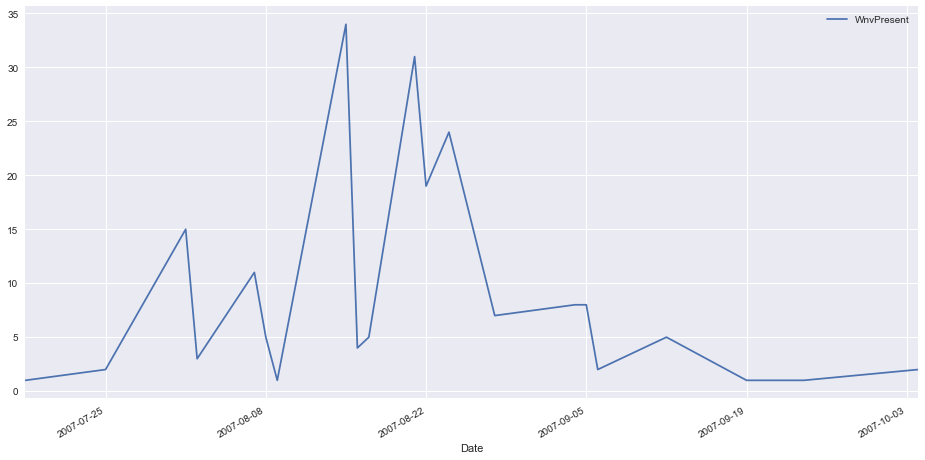

In [140]:
#plotting number of traps containing WNV in 2007
wnv_outbreaks[(wnv_outbreaks.Date > "2006-12-31") & (wnv_outbreaks.Date < "2008-01-01")].plot(x="Date", y="WnvPresent")

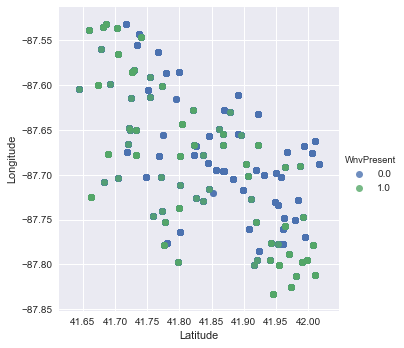

In [141]:
#scatter plot for WNV in 2007 
train_2007 = train[(train.Date > "2006-12-31") & (train.Date < "2008-01-01")]
sns.lmplot(x="Latitude", y="Longitude", data = train_2007, hue="WnvPresent", fit_reg=False)

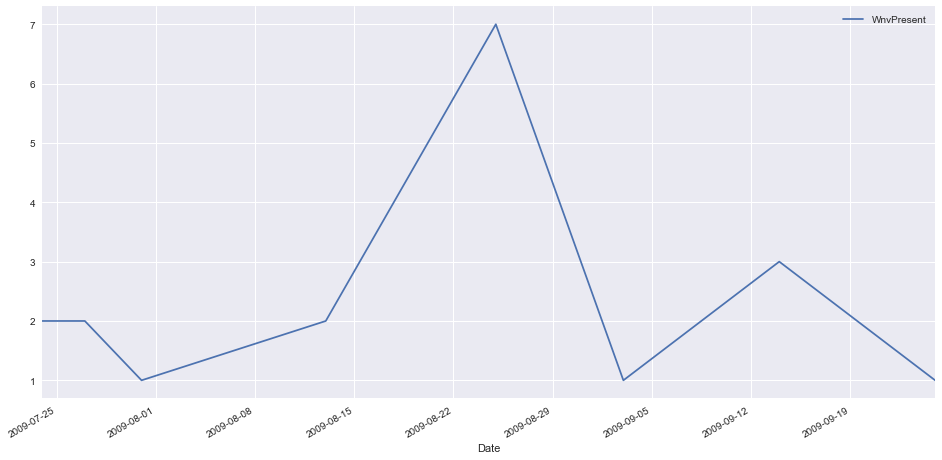

In [142]:
#plotting number of traps containing WNV in 2009
wnv_outbreaks[(wnv_outbreaks.Date > "2008-12-31") & (wnv_outbreaks.Date < "2010-01-01")].plot(x="Date", y="WnvPresent")

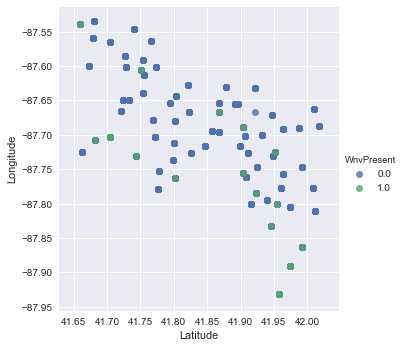

In [143]:
#scatter plot for WNV in 2009 
train_2009 = train[(train.Date > "2008-12-31") & (train.Date < "2010-01-01")]
sns.lmplot(x="Latitude", y="Longitude", data = train_2009, hue="WnvPresent", fit_reg=False)

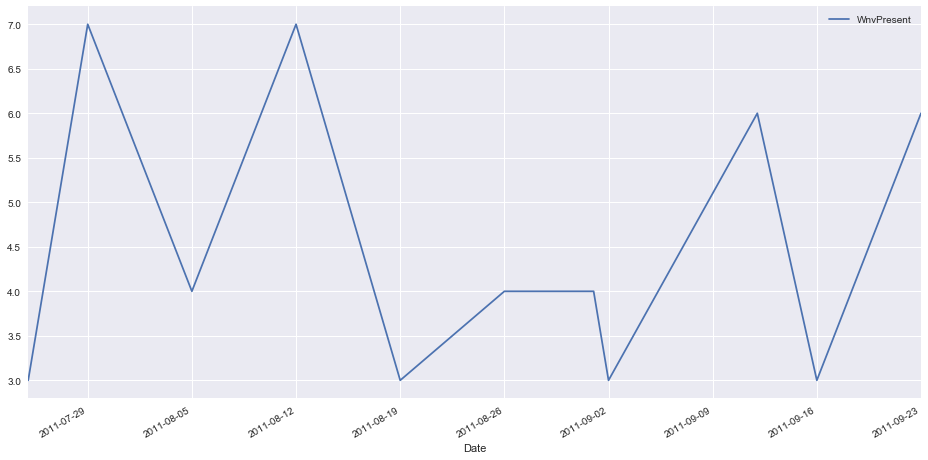

In [144]:
#plotting number of traps containing WNV in 2011
wnv_outbreaks[(wnv_outbreaks.Date > "2010-12-31") & (wnv_outbreaks.Date < "2012-01-01")].plot(x="Date", y="WnvPresent")

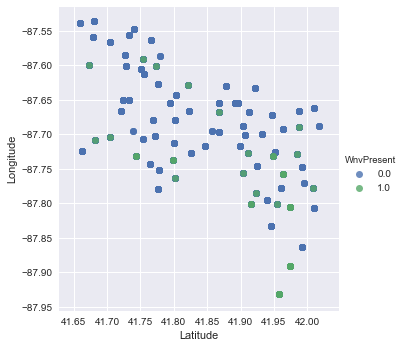

In [145]:
#scatter plot for WNV in 2011 
train_2011 = train[(train.Date > "2010-12-31") & (train.Date < "2012-01-01")]
sns.lmplot(x="Latitude", y="Longitude", data = train_2011, hue="WnvPresent", fit_reg=False)

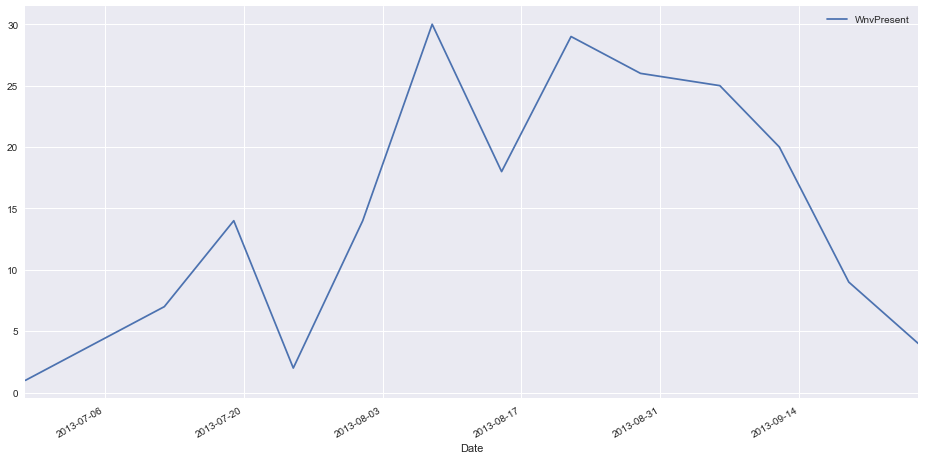

In [146]:
#plotting number of traps containing WNV in 2013
wnv_outbreaks[(wnv_outbreaks.Date > "2012-12-31") & (wnv_outbreaks.Date < "2014-01-01")].plot(x="Date", y="WnvPresent")

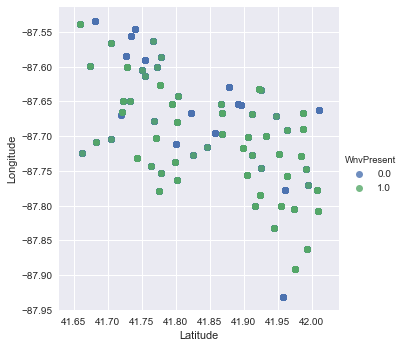

In [147]:
#scatter plot for WNV in 2013 
train_2013 = train[(train.Date > "2012-12-31") & (train.Date < "2014-01-01")]
sns.lmplot(x="Latitude", y="Longitude", data = train_2013, hue="WnvPresent", fit_reg=False)

In [148]:
#How many mosquitos were in traps when WNV was found compared to when not found?
print("Mean number of mosquitos present when WNV is absent vs. present: ")
print(train.groupby("WnvPresent").NumMosquitos.mean())
print
#on average, traps with wnv present had almost nine times as many mosquitos as those without (89.38 vs. 11.75)

#How many mosquitos were in traps when WNV was found compared to when not found?
print("Median number of mosquitos present when WNV is absent vs. present: ")
print(train.groupby("WnvPresent").NumMosquitos.median())
print
#the median number of mosquitos in traps with wnv present almost 8 times greate than those without (23.0 vs. 3.0)

#looking at std of number of mosquitos when WNV is absent vs. present
print("Standard deviation of mosquitos present when WNV is absent vs. present: ")
print(train.groupby("WnvPresent").NumMosquitos.std())
print

#Using mean and std, we can know how many mosquitos were in 68% of traps with and without WNV 
print("Range of Mosquitos in traps without WNV (one STD around Mean): ") 
print(train[train["WnvPresent"]==0].NumMosquitos.mean() - train[train["WnvPresent"]==0].NumMosquitos.std(),
      train[train["WnvPresent"]==0].NumMosquitos.mean() + train[train["WnvPresent"]==0].NumMosquitos.std())
print

print("Range of Mosquitos in traps with WNV (one STD around Mean): ") 
print(train[train["WnvPresent"]==1].NumMosquitos.mean() - train[train["WnvPresent"]==1].NumMosquitos.std(),
      train[train["WnvPresent"]==1].NumMosquitos.mean() + train[train["WnvPresent"]==1].NumMosquitos.std())

#The data on numbers of mosquitos in traps is hugely skewed for both conditions of WnvPresent, especially after 
#combining mosquito numbers across rows that had previously been capped at 50.

#When we scale our data, I would probably consider using the StandardScaler

Mean number of mosquitos present when WNV is absent vs. present: 
WnvPresent
0.0    11.747817
1.0    89.376368
Name: NumMosquitos, dtype: float64

Median number of mosquitos present when WNV is absent vs. present: 
WnvPresent
0.0     3.0
1.0    23.0
Name: NumMosquitos, dtype: float64

Standard deviation of mosquitos present when WNV is absent vs. present: 
WnvPresent
0.0     40.353509
1.0    265.376211
Name: NumMosquitos, dtype: float64

Range of Mosquitos in traps without WNV (one STD around Mean): 
(-28.605691096450933, 52.10132591810221)

Range of Mosquitos in traps with WNV (one STD around Mean): 
(-175.99984359361076, 354.7525788233701)


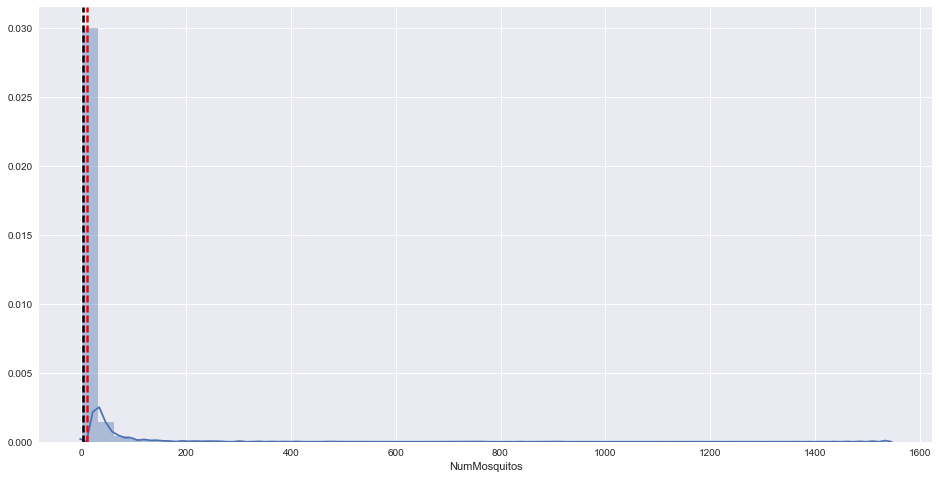

In [149]:
#plotting number of mosquitos in traps without WNV (black is median, red is mean)
no_wnv = sns.distplot(train[train["WnvPresent"]==0].NumMosquitos)
no_wnv.axvline(train[train["WnvPresent"]==0].NumMosquitos.median(), lw=2.5, ls='dashed', color='black')
no_wnv.axvline(train[train["WnvPresent"]==0].NumMosquitos.mean(), lw=2.5, ls='dashed', color='red')

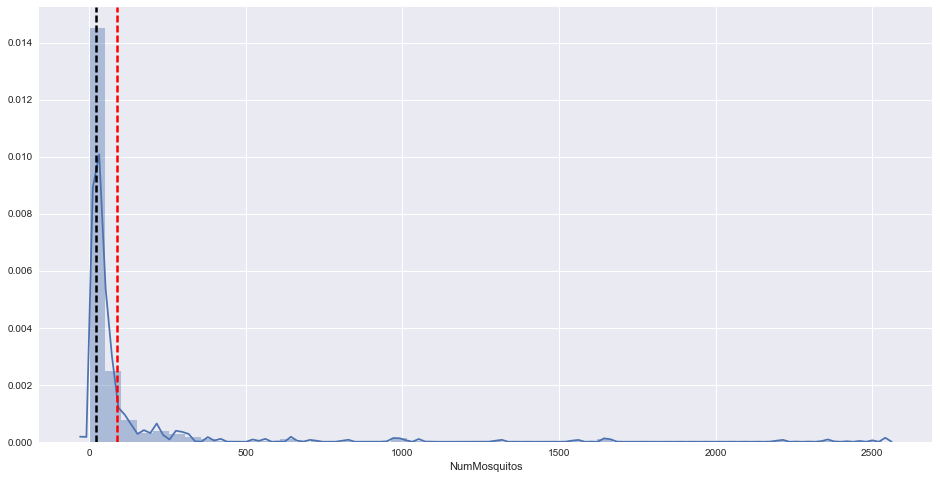

In [150]:
#plotting number of mosquitos in traps with WNV (black is median, red is mean)
wnv = sns.distplot(train[train["WnvPresent"]==1].NumMosquitos)
wnv.axvline(train[train["WnvPresent"]==1].NumMosquitos.median(), lw=2.5, ls='dashed', color='black')
wnv.axvline(train[train["WnvPresent"]==1].NumMosquitos.mean(), lw=2.5, ls='dashed', color='red')

In [151]:
#Which species of mosquitos most typically carried WNV?
#counting number of traps in which WNV is present vs. absent by species
species_groups = train.groupby(["Species", "WnvPresent"]).WnvPresent.count().unstack()

#filling NaN values for species where WNV was never present
species_groups[1].fillna(value=0.0, inplace=True) 

#calculating total traps counted for each species
species_groups["Total"] = species_groups[0] + species_groups[1]

#calculating proportion of all traps for each species in which WNV was present
species_groups["Trap_WNV_Prob"] = (species_groups[1]/species_groups["Total"])

species_groups

#only CULEX PIPIENS, CULEX PIPIENS/RESTUANS, CULEX RESTUANS were found to carry WNV. 
# 9.4% of traps containing CULEX PIPIENS contained WNV; 
# 5.9% of traps containing CULEX PIPIENS/RESTUANS contained WNV; 
# 2.0% of traps containing CULEX RESTUANS contained WNV; 

WnvPresent,0.0,1.0,Total,Trap_WNV_Prob
Species,,,,
CULEX ERRATICUS,1.0,0.0,1.0,0.000000
CULEX PIPIENS,1766.0,184.0,1950.0,0.094359
CULEX PIPIENS/RESTUANS,3601.0,225.0,3826.0,0.058808
CULEX RESTUANS,2345.0,48.0,2393.0,0.020059
CULEX SALINARIUS,83.0,0.0,83.0,0.000000
CULEX TARSALIS,6.0,0.0,6.0,0.000000
CULEX TERRITANS,216.0,0.0,216.0,0.000000


In [152]:
#defining function to check trap statistics for each year in train set (datasets already created above)

def trap_wnv_proportion(train_year):
    trap_groups = train_year.groupby(["Trap","WnvPresent"]).WnvPresent.count().unstack()
    #filling NaN values for species where WNV was never present
    trap_groups[1].fillna(value=0.0, inplace=True) 
    #calculating total traps counted for each species
    trap_groups["Total"] = trap_groups[0] + trap_groups[1]
    #calculating proportion of all traps for each species in which WNV was present
    trap_groups["Trap_WNV_Prob"] = (trap_groups[1]/trap_groups["Total"])
    print"Number of traps recorded in timeframe: ", len(trap_groups)
    print
    print"Number of traps with some wnv detected: ",trap_groups[trap_groups["Trap_WNV_Prob"] > 0.0].shape[0]
    print
    print"Number of traps with no wnv detected: ",trap_groups[trap_groups["Trap_WNV_Prob"] == 0.0].shape[0]
    print
    print"Proportion of total traps with wnv detected at some point during timeframe: ", float(trap_groups[trap_groups["Trap_WNV_Prob"] > 0.0].shape[0])/len(trap_groups) 
    print
    print"Traps sorted by proportion of times wnv was detected when checked"
    print
    return trap_groups.sort_values(by="Trap_WNV_Prob", ascending=False)



In [153]:
#Examining wnv stats by trap for all train years 
#creating dataframe to merge proportions onto train at later point
trap_proportion = trap_wnv_proportion(train)

#resetting index to allow for easier merging
trap_proportion.reset_index(inplace=True)
trap_proportion.head()
#across all train years, 39 traps never had wnv detected.  This could be an important criteria for analysis.

Number of traps recorded in timeframe:  136

Number of traps with some wnv detected:  97

Number of traps with no wnv detected:  39

Proportion of total traps with wnv detected at some point during timeframe:  0.713235294118

Traps sorted by proportion of times wnv was detected when checked



WnvPresent,Trap,0.0,1.0,Total,Trap_WNV_Prob
0,T900,125.0,29.0,154.0,0.188312
1,T143,23.0,5.0,28.0,0.178571
2,T006,20.0,4.0,24.0,0.166667
3,T086,36.0,7.0,43.0,0.162791
4,T014,24.0,4.0,28.0,0.142857


In [154]:
#Which traps had WNV detections / had more than one year / every year?
#adjusting formula to examine all traps, regardless of WNV detection.

def wnv_per_year(train_year):
    wnv_traps = trap_wnv_proportion(train_year)
    #Looking at all traps, regardless of detected WNV in the train year (used to only be looking at traps with at least 1)
    wnv_traps = wnv_traps[wnv_traps[1] >= 0.0]
    #returning list of traps into separate list for future use.
    return wnv_traps[1]

In [155]:
#Which traps had WNV / more than one year / every year?
wnv_2007 = wnv_per_year(train_2007)
wnv_2009 = wnv_per_year(train_2009)
wnv_2011 = wnv_per_year(train_2011)
wnv_2013 = wnv_per_year(train_2013)

#concatenating yearly traps into single dataframe
wnv_all = pd.concat([wnv_2007, wnv_2009, wnv_2011, wnv_2013], axis=1)

wnv_all.fillna(0, inplace=True)
wnv_all.columns = ["2007 WNV Detections", "2009 WNV Detections", "2011 WNV Detections", "2013 WNV Detections"]

wnv_all["Num_Years_Trap_WNV_Detection"] = (wnv_all != 0).sum(axis=1)
wnv_all["Max_One_Year_Trap_WNV_Detections"] = wnv_all[["2007 WNV Detections",
                                                                    "2009 WNV Detections",
                                                                    "2011 WNV Detections",
                                                                    "2013 WNV Detections"]].max(axis=1)
wnv_all["Total_Train_Trap_WNV_Detections"] = wnv_all[["2007 WNV Detections",
                                                                    "2009 WNV Detections",
                                                                    "2011 WNV Detections",
                                                                    "2013 WNV Detections"]].sum(axis=1)


#resetting index to allow later merging more easily.
wnv_all.reset_index(inplace=True)
wnv_all

Number of traps recorded in timeframe:  116

Number of traps with some wnv detected:  69

Number of traps with no wnv detected:  47

Proportion of total traps with wnv detected at some point during timeframe:  0.594827586207

Traps sorted by proportion of times wnv was detected when checked

Number of traps recorded in timeframe:  73

Number of traps with some wnv detected:  16

Number of traps with no wnv detected:  57

Proportion of total traps with wnv detected at some point during timeframe:  0.219178082192

Traps sorted by proportion of times wnv was detected when checked

Number of traps recorded in timeframe:  80

Number of traps with some wnv detected:  23

Number of traps with no wnv detected:  57

Proportion of total traps with wnv detected at some point during timeframe:  0.2875

Traps sorted by proportion of times wnv was detected when checked

Number of traps recorded in timeframe:  74

Number of traps with some wnv detected:  59

Number of traps with no wnv detected:  15


,index,2007 WNV Detections,2009 WNV Detections,2011 WNV Detections,2013 WNV Detections,Num_Years_Trap_WNV_Detection,Max_One_Year_Trap_WNV_Detections,Total_Train_Trap_WNV_Detections
0,T001,0.0,0.0,0.0,0.0,0,0.0,0.0
1,T002,7.0,1.0,1.0,6.0,4,7.0,15.0
2,T003,4.0,0.0,3.0,7.0,3,7.0,14.0
3,T004,0.0,0.0,0.0,0.0,0,0.0,0.0
4,T005,2.0,0.0,0.0,0.0,1,2.0,2.0
5,T006,4.0,0.0,0.0,0.0,1,4.0,4.0
6,T007,0.0,0.0,0.0,0.0,0,0.0,0.0
7,T008,4.0,0.0,1.0,4.0,3,4.0,9.0
8,T009,3.0,1.0,0.0,4.0,3,4.0,8.0
9,T011,7.0,1.0,0.0,3.0,3,7.0,11.0


In [156]:
# Number of training years in which WNV was detected in Trap
# Maximum times Trap contained WNV in one year
# Total times Trap contained WNV across all training years

train = pd.merge(train, wnv_all[["index","Num_Years_Trap_WNV_Detection", "Max_One_Year_Trap_WNV_Detections", 
                                       "Total_Train_Trap_WNV_Detections"]], left_on='Trap', right_on='index')
train.drop("index", axis=1, inplace=True)

#Merging in Trap_WNV_Prob
train = pd.merge(train, trap_proportion[["Trap","Trap_WNV_Prob"]], left_on='Trap', right_on='Trap')

train = train.sort_values(by=['Date', "Trap", "Species"])
train.reset_index(inplace=True, drop=True)
train.head()


,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Year,Parent_Trap,Is_Satellite,Num_Years_Trap_WNV_Detection,Max_One_Year_Trap_WNV_Detections,Total_Train_Trap_WNV_Detections,Trap_WNV_Prob
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1.0,0.0,2007.0,T002,0.0,4,7.0,15.0,0.102041
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1.0,0.0,2007.0,T002,0.0,4,7.0,15.0,0.102041
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1.0,0.0,2007.0,T007,0.0,0,0.0,0.0,0.000000
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1.0,0.0,2007.0,T015,0.0,1,4.0,4.0,0.125000
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,4.0,0.0,2007.0,T015,0.0,1,4.0,4.0,0.125000


In [157]:
#create weighted proportion column for mosquito species - one for each of the three known carriers 
#(CULEX PIPIENS, CULEX PIPIENS/RESTUANS, and CULEX RESTUANS) and one for all others == 0.0
train["Mos_WNV_Prob"] = 0.0
train.ix[train.Species == "CULEX PIPIENS/RESTUANS", "Mos_WNV_Prob"] = 0.058808
train.ix[train.Species == "CULEX PIPIENS", "Mos_WNV_Prob"] = 0.094359
train.ix[train.Species == "CULEX RESTUANS", "Mos_WNV_Prob"] = 0.020059

# create series of feature columns for traps:
    # Traps never containing wnv
train["Trap_Ever_Wnv"] = 0.0
train.ix[train.Num_Years_Trap_WNV_Detection > 0, "Trap_Ever_Wnv"] = 1.0



In [158]:
train.Num_Years_Trap_WNV_Detection.value_counts()# Proporton of times checked that trap had WNV present

1    2742
2    2465
3    1805
0     972
4     491
Name: Num_Years_Trap_WNV_Detection, dtype: int64

In [159]:
train.Species.value_counts()

CULEX PIPIENS/RESTUANS    3826
CULEX RESTUANS            2393
CULEX PIPIENS             1950
CULEX TERRITANS            216
CULEX SALINARIUS            83
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [160]:
#creating rolling averages of number of mosquitos by species
#create separate dfs grouping by date and species, and summing NumMosquitos
#create new columns "NumMos_3ob_avg" which, is an average of the total number of mosquitos of that species within the
#last three observation dates.

#after creating each df, merge dfs back onto train, merging by date and species.
#I'd love to have done this by trap, but it would be significantly more complex

#I appreciate that this poses problems when calculating the averages of the first few observations in each year.
#This is a somewhat rough measure, but hopefully this error will be offset by the other variables to a large extent.

def mos_rolling_obs(species):
    df = train[train["Species"] == species].groupby(["Date", "Species"]).NumMosquitos.sum()
    df = pd.DataFrame(df)
    df.reset_index(inplace=True, drop=False)
    #creating average of last three observation sums, where three prior obs aren't available, 
    #take either 1 or 2 obs (e.g. use of min_periods)
    df["NumMos_3ob_avg"] = df["NumMosquitos"].rolling(window=3, min_periods=1,center=False).mean()
    return df

In [161]:
PIPIENS_RESTUANS = mos_rolling_obs("CULEX PIPIENS/RESTUANS")
RESTUANS = mos_rolling_obs("CULEX RESTUANS")
PIPIENS = mos_rolling_obs("CULEX PIPIENS")
TERRITANS = mos_rolling_obs("CULEX TERRITANS")
SALINARIUS = mos_rolling_obs("CULEX SALINARIUS")
TARSALIS = mos_rolling_obs("CULEX TARSALIS")
ERRATICUS = mos_rolling_obs("CULEX ERRATICUS")

#concatenating all mos-specific dfs on 0-axis, and merging new column onto train set.
all_mos = pd.concat([PIPIENS_RESTUANS, RESTUANS, PIPIENS, TERRITANS, SALINARIUS, TARSALIS, ERRATICUS], axis=0)

train = pd.merge(train, all_mos[["Date", "Species", "NumMos_3ob_avg"]], 
                 left_on=["Date","Species"], right_on=["Date","Species"])


In [162]:
#create a variable that examines probabilty of WNV by trap and by species

trap_mos_groups = train[["Trap","Species","WnvPresent"]].groupby(["Trap","Species","WnvPresent"]).WnvPresent.count().unstack()
#filling NaN values for instances where WNV was never present
trap_mos_groups[1].fillna(value=0.0, inplace=True) 
#calculating total WNV instances counted for each species in each trap
trap_mos_groups["Total"] = trap_mos_groups[0] + trap_mos_groups[1]
#calculating proportion of all traps for each species in which WNV was present
trap_mos_groups["Trap_Species_WNV_Prob"] = (trap_mos_groups[1]/trap_mos_groups["Total"])
trap_mos_groups = trap_mos_groups.sort_values(by="Trap_Species_WNV_Prob", ascending=False)

trap_mos_groups.reset_index(inplace=True)

trap_mos_groups = pd.DataFrame(trap_mos_groups)

#merging Trap_Species_WNV_Prob from trap_mos_groups into train df
train = pd.merge(train, trap_mos_groups[['Trap', "Species", "Trap_Species_WNV_Prob"]], how= "inner", left_on=['Trap', "Species"], 
                 right_on=['Trap', "Species"])

In [163]:
train.shape

(8475, 18)

In [164]:
train.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Year,Parent_Trap,Is_Satellite,Num_Years_Trap_WNV_Detection,Max_One_Year_Trap_WNV_Detections,Total_Train_Trap_WNV_Detections,Trap_WNV_Prob,Mos_WNV_Prob,Trap_Ever_Wnv,NumMos_3ob_avg,Trap_Species_WNV_Prob
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,1.0,0.0,2007.0,T002,0.0,4,7.0,15.0,0.102041,0.058808,1.0,10.000000,0.142857
1,2007-06-05,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,3.0,0.0,2007.0,T002,0.0,4,7.0,15.0,0.102041,0.058808,1.0,19.000000,0.142857
2,2007-06-26,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,1.0,0.0,2007.0,T002,0.0,4,7.0,15.0,0.102041,0.058808,1.0,35.666667,0.142857
3,2007-06-29,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,2.0,0.0,2007.0,T002,0.0,4,7.0,15.0,0.102041,0.058808,1.0,40.333333,0.142857
4,2007-07-02,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,3.0,0.0,2007.0,T002,0.0,4,7.0,15.0,0.102041,0.058808,1.0,75.000000,0.142857


In [165]:
#creating variables that specify: 
    #mean number of mosquito species per trap
    #median number of mosquito species per trap
    #25th percentile of mosquito species per trap
    #75th percentile of mosquito species per trap

trap_spec_mos_mean = train[["Trap","Species","NumMosquitos"]].groupby(["Trap","Species"]).NumMosquitos.mean()
trap_spec_mos_median = train[["Trap","Species","NumMosquitos"]].groupby(["Trap","Species"]).NumMosquitos.median()
trap_spec_mos_25percent = train[["Trap","Species","NumMosquitos"]].groupby(["Trap","Species"]).NumMosquitos.quantile(q=.25)
trap_spec_mos_75percent = train[["Trap","Species","NumMosquitos"]].groupby(["Trap","Species"]).NumMosquitos.quantile(q=.75)

#creating dataframes out of series objects
trap_spec_mos_mean = pd.DataFrame(trap_spec_mos_mean)
trap_spec_mos_median = pd.DataFrame(trap_spec_mos_median)
trap_spec_mos_25percent = pd.DataFrame(trap_spec_mos_25percent)
trap_spec_mos_75percent = pd.DataFrame(trap_spec_mos_75percent)

#Resetting indexes to make dfs easier to work with
trap_spec_mos_mean.reset_index(inplace=True)
trap_spec_mos_median.reset_index(inplace=True)
trap_spec_mos_25percent.reset_index(inplace=True)
trap_spec_mos_75percent.reset_index(inplace=True)

#Renaming generated columns appropriately
trap_spec_mos_mean.rename(columns={'NumMosquitos':'Trap_Species_Mos_Mean'}, inplace=True)
trap_spec_mos_median.rename(columns={'NumMosquitos':'Trap_Species_Mos_Median'}, inplace=True)
trap_spec_mos_25percent.rename(columns={'NumMosquitos':'Trap_Species_Mos_25percent'}, inplace=True)
trap_spec_mos_75percent.rename(columns={'NumMosquitos':'Trap_Species_Mos_75percent'}, inplace=True)

#merging dfs together before merging with train data
trap_spec_mos_nums = pd.merge(trap_spec_mos_mean, trap_spec_mos_median[["Trap", "Species", "Trap_Species_Mos_Median"]], 
                              left_on=["Trap", "Species"], right_on=["Trap", "Species"])

trap_spec_mos_nums = pd.merge(trap_spec_mos_nums, trap_spec_mos_25percent[["Trap", "Species", "Trap_Species_Mos_25percent"]], 
                              left_on=["Trap", "Species"], right_on=["Trap", "Species"])

trap_spec_mos_nums = pd.merge(trap_spec_mos_nums, trap_spec_mos_75percent[["Trap", "Species", "Trap_Species_Mos_75percent"]], 
                              left_on=["Trap", "Species"], right_on=["Trap", "Species"])

trap_spec_mos_nums.head(10)

,Trap,Species,Trap_Species_Mos_Mean,Trap_Species_Mos_Median,Trap_Species_Mos_25percent,Trap_Species_Mos_75percent
0,T001,CULEX PIPIENS,1.666667,1.0,1.0,1.0
1,T001,CULEX PIPIENS/RESTUANS,2.000000,1.0,1.0,2.5
2,T001,CULEX TERRITANS,1.000000,1.0,1.0,1.0
3,T002,CULEX PIPIENS,15.837838,7.0,3.0,32.0
4,T002,CULEX PIPIENS/RESTUANS,30.650794,14.0,4.0,29.0
5,T002,CULEX RESTUANS,26.466667,7.0,3.0,17.0
6,T002,CULEX SALINARIUS,1.000000,1.0,1.0,1.0
7,T002,CULEX TERRITANS,1.000000,1.0,1.0,1.0
8,T003,CULEX PIPIENS,8.920000,3.0,1.0,13.0
9,T003,CULEX PIPIENS/RESTUANS,16.943396,8.0,3.0,22.0


In [166]:
#Doing Similar transformation just for trap number (regardless of species inside). This will hopefully help with 
#ambiguous species in test set.

#creating variables that specify: 
    #mean number of mosquitos per trap
    #median number of mosquitos per trap
    #25th percentile of mosquitos per trap
    #75th percentile of mosquitos per trap

trap_mos_mean = train[["Trap","NumMosquitos"]].groupby(["Trap"]).NumMosquitos.mean()
trap_mos_median = train[["Trap","NumMosquitos"]].groupby(["Trap"]).NumMosquitos.median()
trap_mos_25percent = train[["Trap","NumMosquitos"]].groupby(["Trap"]).NumMosquitos.quantile(q=.25)
trap_mos_75percent = train[["Trap","NumMosquitos"]].groupby(["Trap"]).NumMosquitos.quantile(q=.75)

#creating dataframes out of series objects
trap_mos_mean = pd.DataFrame(trap_mos_mean)
trap_mos_median = pd.DataFrame(trap_mos_median)
trap_mos_25percent = pd.DataFrame(trap_mos_25percent)
trap_mos_75percent = pd.DataFrame(trap_mos_75percent)

#Resetting indexes to make dfs easier to work with
trap_mos_mean.reset_index(inplace=True)
trap_mos_median.reset_index(inplace=True)
trap_mos_25percent.reset_index(inplace=True)
trap_mos_75percent.reset_index(inplace=True)

#Renaming generated columns appropriately
trap_mos_mean.rename(columns={'NumMosquitos':'Trap_Mos_Mean'}, inplace=True)
trap_mos_median.rename(columns={'NumMosquitos':'Trap_Mos_Median'}, inplace=True)
trap_mos_25percent.rename(columns={'NumMosquitos':'Trap_Mos_25percent'}, inplace=True)
trap_mos_75percent.rename(columns={'NumMosquitos':'Trap_Mos_75percent'}, inplace=True)

#merging dfs together before merging with train data
trap_mos_nums = pd.merge(trap_mos_mean, trap_mos_median[["Trap", "Trap_Mos_Median"]], 
                              left_on=["Trap"], right_on=["Trap"])

trap_mos_nums = pd.merge(trap_mos_nums, trap_mos_25percent[["Trap", "Trap_Mos_25percent"]], 
                              left_on=["Trap"], right_on=["Trap"])

trap_mos_nums = pd.merge(trap_mos_nums, trap_mos_75percent[["Trap", "Trap_Mos_75percent"]], 
                              left_on=["Trap"], right_on=["Trap"])

trap_mos_nums.head(10)

,Trap,Trap_Mos_Mean,Trap_Mos_Median,Trap_Mos_25percent,Trap_Mos_75percent
0,T001,1.785714,1.0,1.00,1.75
1,T002,25.238095,10.0,3.00,24.00
2,T003,11.911504,5.0,2.00,13.00
3,T004,4.916667,2.5,1.00,6.25
4,T005,3.571429,2.5,1.25,4.75
5,T006,4.458333,1.5,1.00,4.50
6,T007,3.347826,3.0,1.00,4.00
7,T008,23.610619,10.0,3.00,39.00
8,T009,20.208333,6.5,2.00,28.25
9,T011,10.488000,5.0,2.00,11.00


In [167]:
#Once more just for species, to help in estimating mosquito numbers where no trap data is available in the train set.

#creating variables that specify: 
    #mean number of mosquito species
    #median number of mosquito species
    #25th percentile of mosquito species 
    #75th percentile of mosquito species
    #species' proportional appearance among all mosquitos counted

spec_mos_mean = train[["Species","NumMosquitos"]].groupby(["Species"]).NumMosquitos.mean()
spec_mos_median = train[["Species","NumMosquitos"]].groupby(["Species"]).NumMosquitos.median()
spec_mos_25percent = train[["Species","NumMosquitos"]].groupby(["Species"]).NumMosquitos.quantile(q=.25)
spec_mos_75percent = train[["Species","NumMosquitos"]].groupby(["Species"]).NumMosquitos.quantile(q=.75)
spec_mos_proportion = train[["Species","NumMosquitos"]].groupby(["Species"]).NumMosquitos.sum()

#creating dataframes out of series objects
spec_mos_mean = pd.DataFrame(spec_mos_mean)
spec_mos_median = pd.DataFrame(spec_mos_median)
spec_mos_25percent = pd.DataFrame(spec_mos_25percent)
spec_mos_75percent = pd.DataFrame(spec_mos_75percent)

spec_mos_proportion = pd.DataFrame(spec_mos_proportion)
total_mos = spec_mos_proportion.NumMosquitos.sum()
spec_mos_proportion["Species_Obs_Proportion"] = spec_mos_proportion.NumMosquitos/total_mos

#Resetting indexes to make dfs easier to work with
spec_mos_mean.reset_index(inplace=True)
spec_mos_median.reset_index(inplace=True)
spec_mos_25percent.reset_index(inplace=True)
spec_mos_75percent.reset_index(inplace=True)
spec_mos_proportion.reset_index(inplace=True)

#Renaming generated columns appropriately
spec_mos_mean.rename(columns={'NumMosquitos':'Species_Mos_Mean'}, inplace=True)
spec_mos_median.rename(columns={'NumMosquitos':'Species_Mos_Median'}, inplace=True)
spec_mos_25percent.rename(columns={'NumMosquitos':'Species_Mos_25percent'}, inplace=True)
spec_mos_75percent.rename(columns={'NumMosquitos':'Species_Mos_75percent'}, inplace=True)

#merging dfs together before merging with train data
spec_mos_nums = pd.merge(spec_mos_mean, spec_mos_median[["Species", "Species_Mos_Median"]], 
                              left_on=["Species"], right_on=["Species"])

spec_mos_nums = pd.merge(spec_mos_nums, spec_mos_25percent[["Species", "Species_Mos_25percent"]], 
                              left_on=["Species"], right_on=["Species"])

spec_mos_nums = pd.merge(spec_mos_nums, spec_mos_75percent[["Species", "Species_Mos_75percent"]], 
                              left_on=["Species"], right_on=["Species"])

spec_mos_nums = pd.merge(spec_mos_nums, spec_mos_proportion[["Species", "Species_Obs_Proportion"]], 
                              left_on=["Species"], right_on=["Species"])

spec_mos_nums.head(10)

,Species,Species_Mos_Mean,Species_Mos_Median,Species_Mos_25percent,Species_Mos_75percent,Species_Obs_Proportion
0,CULEX ERRATICUS,7.000000,7.0,7.0,7.0,0.000052
1,CULEX PIPIENS,22.908205,4.0,2.0,10.0,0.330801
2,CULEX PIPIENS/RESTUANS,17.320439,5.0,2.0,14.0,0.490732
3,CULEX RESTUANS,9.791475,3.0,1.0,8.0,0.173513
4,CULEX SALINARIUS,1.746988,1.0,1.0,2.0,0.001074
5,CULEX TARSALIS,1.166667,1.0,1.0,1.0,0.000052
6,CULEX TERRITANS,2.361111,1.0,1.0,2.0,0.003777


In [168]:
#joining the various dfs created above to train

train = pd.merge(train, trap_spec_mos_nums[["Trap", "Species", "Trap_Species_Mos_Mean", "Trap_Species_Mos_Median", 
                                            "Trap_Species_Mos_25percent", "Trap_Species_Mos_75percent"]], 
                 left_on=["Trap", "Species"], right_on=["Trap", "Species"])

train = pd.merge(train, trap_mos_nums[["Trap", "Trap_Mos_Mean", "Trap_Mos_Median", "Trap_Mos_25percent", 
                                       "Trap_Mos_75percent"]], 
                 left_on=["Trap"], right_on=["Trap"])

train = pd.merge(train, spec_mos_nums[["Species", "Species_Mos_Mean", "Species_Mos_Median", "Species_Mos_25percent",
                                       "Species_Mos_75percent", "Species_Obs_Proportion"]], 
                 left_on=["Species"], right_on=["Species"])

train

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Year,Parent_Trap,Is_Satellite,...,Trap_Species_Mos_75percent,Trap_Mos_Mean,Trap_Mos_Median,Trap_Mos_25percent,Trap_Mos_75percent,Species_Mos_Mean,Species_Mos_Median,Species_Mos_25percent,Species_Mos_75percent,Species_Obs_Proportion
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1.0,0.0,2007.0,T002,0.0,...,29.00,25.238095,10.0,3.0,24.00,17.320439,5.0,2.0,14.0,0.490732
1,2007-06-05,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,3.0,0.0,2007.0,T002,0.0,...,29.00,25.238095,10.0,3.0,24.00,17.320439,5.0,2.0,14.0,0.490732
2,2007-06-26,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1.0,0.0,2007.0,T002,0.0,...,29.00,25.238095,10.0,3.0,24.00,17.320439,5.0,2.0,14.0,0.490732
3,2007-06-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,2.0,0.0,2007.0,T002,0.0,...,29.00,25.238095,10.0,3.0,24.00,17.320439,5.0,2.0,14.0,0.490732
4,2007-07-02,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,3.0,0.0,2007.0,T002,0.0,...,29.00,25.238095,10.0,3.0,24.00,17.320439,5.0,2.0,14.0,0.490732
5,2007-07-11,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,18.0,0.0,2007.0,T002,0.0,...,29.00,25.238095,10.0,3.0,24.00,17.320439,5.0,2.0,14.0,0.490732
6,2007-07-18,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,7.0,0.0,2007.0,T002,0.0,...,29.00,25.238095,10.0,3.0,24.00,17.320439,5.0,2.0,14.0,0.490732
7,2007-07-27,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,23.0,0.0,2007.0,T002,0.0,...,29.00,25.238095,10.0,3.0,24.00,17.320439,5.0,2.0,14.0,0.490732
8,2007-08-01,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,104.0,1.0,2007.0,T002,0.0,...,29.00,25.238095,10.0,3.0,24.00,17.320439,5.0,2.0,14.0,0.490732
9,2007-08-07,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,13.0,0.0,2007.0,T002,0.0,...,29.00,25.238095,10.0,3.0,24.00,17.320439,5.0,2.0,14.0,0.490732


In [169]:
train.columns

Index([u'Date', u'Species', u'Trap', u'Latitude', u'Longitude',
       u'NumMosquitos', u'WnvPresent', u'Year', u'Parent_Trap',
       u'Is_Satellite', u'Num_Years_Trap_WNV_Detection',
       u'Max_One_Year_Trap_WNV_Detections', u'Total_Train_Trap_WNV_Detections',
       u'Trap_WNV_Prob', u'Mos_WNV_Prob', u'Trap_Ever_Wnv', u'NumMos_3ob_avg',
       u'Trap_Species_WNV_Prob', u'Trap_Species_Mos_Mean',
       u'Trap_Species_Mos_Median', u'Trap_Species_Mos_25percent',
       u'Trap_Species_Mos_75percent', u'Trap_Mos_Mean', u'Trap_Mos_Median',
       u'Trap_Mos_25percent', u'Trap_Mos_75percent', u'Species_Mos_Mean',
       u'Species_Mos_Median', u'Species_Mos_25percent',
       u'Species_Mos_75percent', u'Species_Obs_Proportion'],
      dtype='object')

In [170]:
#saving new clean train for further imputation to test data.
#train.to_csv("clean_train_2.csv")

In [171]:
#scaling train data - use .iloc method
#Ultimately decided not to use NumMosquitos, Parent_Trap, Is_Satellite, Trap_Ever_WNV, and NumMos_3ob_avg in modeling 
#Couldn't use NumMosquitos because we couldn't effectively model NumMosquitos predictions for the test set
#Trap_Ever_WNV is effectively covered by other columns (e.g., Num_Years_Trap_WNV_Detection)
#NumMos_3ob_avg won't be useful with the test data because we were never able to 

copy_train = train.copy()
copy_train.drop(["Species", "Trap", 'NumMosquitos', 'Year', 'Parent_Trap', 'Is_Satellite', "Trap_Ever_Wnv",
                 "WnvPresent", "NumMos_3ob_avg"], axis=1, inplace=True)

#start here / above
scaled_train = StandardScaler().fit_transform(copy_train.iloc[:,1:])

scaled_train = pd.DataFrame(scaled_train, columns = copy_train.columns[1:])

#adding date values and unscaled WnvPresent into scaled dataframe
scaled_train["Date"] = train["Date"]
scaled_train["WnvPresent"] = train["WnvPresent"]

scaled_train.head()


,Latitude,Longitude,Num_Years_Trap_WNV_Detection,Max_One_Year_Trap_WNV_Detections,Total_Train_Trap_WNV_Detections,Trap_WNV_Prob,Mos_WNV_Prob,Trap_Species_WNV_Prob,Trap_Species_Mos_Mean,Trap_Species_Mos_Median,...,Trap_Mos_Median,Trap_Mos_25percent,Trap_Mos_75percent,Species_Mos_Mean,Species_Mos_Median,Species_Mos_25percent,Species_Mos_75percent,Species_Obs_Proportion,Date,WnvPresent
0,1.032541,-1.263449,2.050194,1.162658,1.998768,1.154647,0.17102,1.395763,0.430885,0.767258,...,0.81011,0.791777,0.502594,0.255114,0.913742,0.676959,0.97549,0.967227,2007-05-29,0.0
1,1.032541,-1.263449,2.050194,1.162658,1.998768,1.154647,0.17102,1.395763,0.430885,0.767258,...,0.81011,0.791777,0.502594,0.255114,0.913742,0.676959,0.97549,0.967227,2007-06-05,0.0
2,1.032541,-1.263449,2.050194,1.162658,1.998768,1.154647,0.17102,1.395763,0.430885,0.767258,...,0.81011,0.791777,0.502594,0.255114,0.913742,0.676959,0.97549,0.967227,2007-06-26,0.0
3,1.032541,-1.263449,2.050194,1.162658,1.998768,1.154647,0.17102,1.395763,0.430885,0.767258,...,0.81011,0.791777,0.502594,0.255114,0.913742,0.676959,0.97549,0.967227,2007-06-29,0.0
4,1.032541,-1.263449,2.050194,1.162658,1.998768,1.154647,0.17102,1.395763,0.430885,0.767258,...,0.81011,0.791777,0.502594,0.255114,0.913742,0.676959,0.97549,0.967227,2007-07-02,0.0


In [172]:
sorted(scaled_train.columns)

['Date',
 'Latitude',
 'Longitude',
 'Max_One_Year_Trap_WNV_Detections',
 'Mos_WNV_Prob',
 'Num_Years_Trap_WNV_Detection',
 'Species_Mos_25percent',
 'Species_Mos_75percent',
 'Species_Mos_Mean',
 'Species_Mos_Median',
 'Species_Obs_Proportion',
 'Total_Train_Trap_WNV_Detections',
 'Trap_Mos_25percent',
 'Trap_Mos_75percent',
 'Trap_Mos_Mean',
 'Trap_Mos_Median',
 'Trap_Species_Mos_25percent',
 'Trap_Species_Mos_75percent',
 'Trap_Species_Mos_Mean',
 'Trap_Species_Mos_Median',
 'Trap_Species_WNV_Prob',
 'Trap_WNV_Prob',
 'WnvPresent']

### Examining and Preparing Weather Data to Merge with Train Data

In [173]:
#reading in weather data
weather = pd.read_csv("weather.csv")
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [174]:
weather = weather[weather.Station == 1]
#since there are a lot of missing values in station 2, we decided to just work with the station 1 data

In [175]:
#Imputing missing values of Tavg with the average of TMax and TMin
weather.ix[weather.Tavg == "M", "Tavg"] = ((weather.Tmax + weather.Tmin)/2)

In [176]:
#inputting "T" values in PrecipTotal to .001, as NOAA considers any precipitation less than .01 to be "Trace", 
# so to be conservative, we imputed T values as .001, so that it's still greater than 0.0. 
weather.ix[weather["PrecipTotal"] == "  T", "PrecipTotal"] = 0.001

#Converting PrecipTotal to float
weather.PrecipTotal = weather.PrecipTotal.astype('float')

#Converting Date to Datetime
weather["Date"] = pd.to_datetime(weather["Date"], infer_datetime_format=True)

weather['Tavg']= weather['Tavg'].astype('float')
weather["AvgSpeed"] = weather["AvgSpeed"].astype('float')
# weather.StnPressure.fillna(method='pad', inplace=True)
#filling nan values using the pad method
#http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html

#replacing the Ms with NaNs so I can impute them easier. 
weather.StnPressure = weather.StnPressure.str.replace(r'M', 'NaN')
weather.fillna(method='pad')
weather['StnPressure']= weather['StnPressure'].astype('float')
weather.StnPressure.fillna(method='pad', inplace=True)


#Adding a column to generate 7-day average of PrecipTotal
weather["Precip_7d_avg"] = weather["PrecipTotal"].rolling(window=7, min_periods=1, center=False).mean()

#creating a column that indicates if average windspeed was greater than 1 std above the mean
#wind speeds this high appeared associated with lower numbers of mosquitos and lower instances of WNV
air_speed_thresh = weather.AvgSpeed.mean() + weather.AvgSpeed.std()
weather["wind_abv_1std"] = 0.0
weather.ix[weather["AvgSpeed"] > air_speed_thresh, "wind_abv_1std"] = 1.0


#dropping Depart, Wetbulb, Heat, Cool, Sunrise, Sunset, SeaLevel, ResultSpeed, "CodeSum","Depth","Station", "SnowFall",
#"Water1" from weather, as many of these columns seem either duplicative or unimportant for purposes of this analysis
#after conducting EDA of weather, also dropping Tmax, Tmin, and ResultDir

weather.drop(["Tmax", "Tmin", "ResultDir","Depart", "WetBulb", "Heat", "Cool", "Sunrise", "Sunset", "SeaLevel", 
              "ResultSpeed", "CodeSum","Depth","Station", "SnowFall", "Water1"], axis=1, inplace=True)


weather.reset_index(inplace=True, drop=True)
weather.head(20)

,Date,Tavg,DewPoint,PrecipTotal,StnPressure,AvgSpeed,Precip_7d_avg,wind_abv_1std
0,2007-05-01,67.0,51,0.000,29.10,9.2,0.000000,0.0
1,2007-05-02,51.0,42,0.000,29.38,13.4,0.000000,1.0
2,2007-05-03,56.0,40,0.000,29.39,11.9,0.000000,1.0
3,2007-05-04,58.0,41,0.001,29.31,10.8,0.000250,0.0
4,2007-05-05,60.0,38,0.001,29.40,12.0,0.000400,1.0
5,2007-05-06,59.0,30,0.000,29.57,15.0,0.000333,1.0
6,2007-05-07,65.0,41,0.001,29.38,10.5,0.000429,0.0
7,2007-05-08,68.0,58,0.000,29.29,5.8,0.000429,0.0
8,2007-05-09,69.0,59,0.130,29.21,6.2,0.019000,0.0
9,2007-05-10,70.0,52,0.000,29.20,4.1,0.019000,0.0


In [177]:
weather.dtypes

Date             datetime64[ns]
Tavg                    float64
DewPoint                  int64
PrecipTotal             float64
StnPressure             float64
AvgSpeed                float64
Precip_7d_avg           float64
wind_abv_1std           float64
dtype: object

In [178]:
#weather.to_csv('clean_weather.csv')
weather.isnull().sum()
len(weather)

1472

In [179]:
#scaling weather data before merging with train data, to take advantage of ALL weather data when scaling, rather than
#just observations that would appear in the train set
# scaled_weather = StandardScaler().fit_transform(weather.iloc[:,1:])

# scaled_weather = pd.DataFrame(scaled_weather, columns = weather.columns[1:])
scaled_weather = StandardScaler().fit_transform(weather[["Tavg", "DewPoint", "PrecipTotal", "StnPressure", 
                                                                     "AvgSpeed", "Precip_7d_avg"]])

scaled_weather = pd.DataFrame(scaled_weather, columns = ["Tavg", "DewPoint", "PrecipTotal", "StnPressure", 
                                                                     "AvgSpeed", "Precip_7d_avg"])

#adding date values into scaled dataframe
scaled_weather["Date"] = weather["Date"]
scaled_weather["wind_abv_1std"] = weather["wind_abv_1std"]

scaled_weather.head()

,Tavg,DewPoint,PrecipTotal,StnPressure,AvgSpeed,Precip_7d_avg,Date,wind_abv_1std
0,0.037433,-0.222912,-0.319916,-0.987494,0.197482,-0.755462,2007-05-01,0.0
1,-1.485236,-1.066664,-0.319916,0.806746,1.515681,-0.755462,2007-05-02,1.0
2,-1.009402,-1.254164,-0.319916,0.870826,1.044896,-0.755462,2007-05-03,1.0
3,-0.819068,-1.160414,-0.317540,0.358186,0.699653,-0.754059,2007-05-04,0.0
4,-0.628734,-1.441665,-0.317540,0.934906,1.076281,-0.753217,2007-05-05,1.0


### Merging Weather and Train Data

In [180]:
#merging scaled_weather with scaled_train data to prepare for modeling
combine = pd.merge(scaled_weather, scaled_train, how= "inner", left_on='Date', right_on='Date')

combine.head()

,Tavg,DewPoint,PrecipTotal,StnPressure,AvgSpeed,Precip_7d_avg,Date,wind_abv_1std,Latitude,Longitude,...,Trap_Mos_Mean,Trap_Mos_Median,Trap_Mos_25percent,Trap_Mos_75percent,Species_Mos_Mean,Species_Mos_Median,Species_Mos_25percent,Species_Mos_75percent,Species_Obs_Proportion,WnvPresent
0,0.703601,0.43334,-0.319916,0.870826,-0.649931,0.103875,2007-05-29,0.0,1.032541,-1.263449,...,0.384598,0.810110,0.791777,0.502594,0.255114,0.913742,0.676959,0.97549,0.967227,0.0
1,0.703601,0.43334,-0.319916,0.870826,-0.649931,0.103875,2007-05-29,0.0,1.214515,-1.546838,...,-0.440330,-0.370459,-0.609928,-0.542962,0.255114,0.913742,0.676959,0.97549,0.967227,0.0
2,0.703601,0.43334,-0.319916,0.870826,-0.649931,0.103875,2007-05-29,0.0,0.210971,0.482575,...,-0.124542,0.135499,0.090925,0.117389,0.255114,0.913742,0.676959,0.97549,0.967227,0.0
3,0.703601,0.43334,-0.319916,0.870826,-0.649931,0.103875,2007-05-29,0.0,0.700966,0.006295,...,-0.482957,-0.707764,-0.609928,-0.653020,0.255114,0.913742,0.676959,0.97549,0.967227,0.0
4,0.703601,0.43334,-0.319916,0.870826,-0.649931,0.103875,2007-05-29,0.0,0.725562,0.745953,...,-0.312977,-0.201806,0.090925,-0.322845,0.255114,0.913742,0.676959,0.97549,0.967227,0.0


In [181]:
X = combine.copy()

#Dropping Date, and WnvPresent (target variable)
X.drop(["Date", "WnvPresent"], 
       axis=1, inplace=True)

#preparing y values
y = combine["WnvPresent"]

In [182]:
#creating function to test and fit classification model
def do_cm_cr(model, X, y, names): 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
    model.fit(X_train, y_train)
    y_probs = model.predict(X_test)    #predict y values for X_test
    print "Output for Tested Model:"
    print "Confusion Matrix of Predictions: "
    print
    print(confusion_matrix(y_test, y_probs)) # Actual values are rows (0, 1), while predicted are columns (0, 1); 
    print
    #printing classification report
    #precision is true positives / (true positives + false positives) - of all predicted, % correct
    #recall is true positives / (true positives + false negatives) - of all actual, % correct
    #f1-score is a weighted harmonic mean of the precision and recall, f1-score reaches best value at 1 and worst at 0.
    #support is number of true values for each class
    print "Classification Matrix: "
    print
    print(classification_report(y_test, y_probs, target_names=names))
    return model.score(X_test,y_test)

In [183]:
#Examining outputs of different models

In [184]:
#Start with Logistic Regression
logreg = LogisticRegression()

do_cm_cr(logreg, X, y, ["no_Wnv", "yes_Wnv"])


Output for Tested Model:
Confusion Matrix of Predictions: 

[[2642    4]
 [ 146    5]]

Classification Matrix: 

             precision    recall  f1-score   support

     no_Wnv       0.95      1.00      0.97      2646
    yes_Wnv       0.56      0.03      0.06       151

avg / total       0.93      0.95      0.92      2797



0.94637111190561318

In [185]:
#k-nearest neighbors
knnc = KNeighborsClassifier()

do_cm_cr(knnc, X, y, ["no_Wnv", "yes_Wnv"])

Output for Tested Model:
Confusion Matrix of Predictions: 

[[2632   14]
 [ 149    2]]

Classification Matrix: 

             precision    recall  f1-score   support

     no_Wnv       0.95      0.99      0.97      2646
    yes_Wnv       0.12      0.01      0.02       151

avg / total       0.90      0.94      0.92      2797



0.94172327493743302

In [186]:
#SVM with linear kernal
lin_svm = svm.SVC(kernel='linear')

do_cm_cr(lin_svm, X, y, ["no_Wnv", "yes_Wnv"])

#SVM with linear model predict 0 instances of WNV - wow.

Output for Tested Model:
Confusion Matrix of Predictions: 

[[2646    0]
 [ 151    0]]

Classification Matrix: 

             precision    recall  f1-score   support

     no_Wnv       0.95      1.00      0.97      2646
    yes_Wnv       0.00      0.00      0.00       151

avg / total       0.89      0.95      0.92      2797



/Users/michaelsalmon/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.94601358598498386

In [187]:
#SVM with rbf kernal
rbf_svm = svm.SVC(kernel='rbf')

do_cm_cr(rbf_svm, X, y, ["no_Wnv", "yes_Wnv"])

#SVM with rbf model predicted also comes up with nothing.

Output for Tested Model:
Confusion Matrix of Predictions: 

[[2646    0]
 [ 151    0]]

Classification Matrix: 

             precision    recall  f1-score   support

     no_Wnv       0.95      1.00      0.97      2646
    yes_Wnv       0.00      0.00      0.00       151

avg / total       0.89      0.95      0.92      2797



0.94601358598498386

In [188]:
#normal decision tree
drc = DecisionTreeClassifier()

do_cm_cr(drc, X, y, ["no_Wnv", "yes_Wnv"])

Output for Tested Model:
Confusion Matrix of Predictions: 

[[2523  123]
 [ 114   37]]

Classification Matrix: 

             precision    recall  f1-score   support

     no_Wnv       0.96      0.95      0.96      2646
    yes_Wnv       0.23      0.25      0.24       151

avg / total       0.92      0.92      0.92      2797



0.91526635681086876

In [189]:
#random forest
rfc = RandomForestClassifier()

do_cm_cr(rfc, X, y, ["no_Wnv", "yes_Wnv"])

Output for Tested Model:
Confusion Matrix of Predictions: 

[[2637    9]
 [ 143    8]]

Classification Matrix: 

             precision    recall  f1-score   support

     no_Wnv       0.95      1.00      0.97      2646
    yes_Wnv       0.47      0.05      0.10       151

avg / total       0.92      0.95      0.92      2797



0.94565606006435465

In [190]:
#gradient boosting classifier
gbc = GradientBoostingClassifier()

do_cm_cr(gbc, X, y, ["no_Wnv", "yes_Wnv"])


Output for Tested Model:
Confusion Matrix of Predictions: 

[[2636   10]
 [ 137   14]]

Classification Matrix: 

             precision    recall  f1-score   support

     no_Wnv       0.95      1.00      0.97      2646
    yes_Wnv       0.58      0.09      0.16       151

avg / total       0.93      0.95      0.93      2797



0.94744368966750092

In [191]:
#gradient boosting classifier
gbc = GradientBoostingClassifier()

bc = BaggingClassifier(gbc)

do_cm_cr(bc, X, y, ["no_Wnv", "yes_Wnv"])



Output for Tested Model:
Confusion Matrix of Predictions: 

[[2639    7]
 [ 140   11]]

Classification Matrix: 

             precision    recall  f1-score   support

     no_Wnv       0.95      1.00      0.97      2646
    yes_Wnv       0.61      0.07      0.13       151

avg / total       0.93      0.95      0.93      2797



0.94744368966750092

In [192]:
#After examining the various models, we decided to more forward with a Bagged Gradient Boosting Classifier. 
#The predicted accuracy of the bagged gradient boosting classifier was effectively the same as the standard 
#GBC, and we felt as though the bagging process had the potential correct for some inherent error in the singular GBC
#by creating an ensemble model.


## Preparing Test File for Modeling Predictions

In [193]:
#reading in test file
test = pd.read_csv("../assets/test.csv")
test["Date"] = pd.to_datetime(test["Date"], infer_datetime_format=True)

#Creating "Parent Trap" column that will indicate all traps associated with a parent trap (e.g., T002A would be T002)
test["Parent_Trap"] = test["Trap"].str[:4]


In [195]:
#To prepare the test file, we'll utilize the unscaled train data from above to create the same columns for the test
#data - this will naturally involve a fair bit of data imputaton to fill in values that we cannot reference from
#the train data

#isolating and merging Mos_WNV_Prob variable from train into test set

mos_wnv_prob = train.groupby(["Species", "Mos_WNV_Prob"]).size()
mos_wnv_prob = pd.DataFrame(mos_wnv_prob)
mos_wnv_prob.reset_index(inplace=True)

#since we'll need to inpute Mos_WNV_Prob for "UNSPECIFIED CULEX", we'll take the proportion of total WNV detections
#in the train data divided by the total number of observations - essentially, the probability that any trap with 
#mosquitos of any type had WNV.

unspecified_wnv = train["WnvPresent"].sum() / train["WnvPresent"].count()

#Merging Mos_WNV_Prob onto test data.
test = pd.merge(test, mos_wnv_prob[["Species", "Mos_WNV_Prob"]],how="left", left_on='Species', right_on='Species')

#inputting averaged wnv probability into NaN values following merge
test["Mos_WNV_Prob"].fillna(value=unspecified_wnv, inplace=True)

test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Parent_Trap,Mos_WNV_Prob
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,T002,0.058808
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,T002,0.020059
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,T002,0.094359
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,T002,0.000000
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,T002,0.000000


In [196]:
# Adding trap-specific variables from train set onto test set
trap_wnv_prob = train.groupby(['Trap', "Num_Years_Trap_WNV_Detection", "Max_One_Year_Trap_WNV_Detections",
                               "Total_Train_Trap_WNV_Detections", "Trap_WNV_Prob"]).size()
trap_wnv_prob = pd.DataFrame(trap_wnv_prob)
trap_wnv_prob.reset_index(inplace=True)

test = pd.merge(test, trap_wnv_prob[["Trap", "Num_Years_Trap_WNV_Detection", "Max_One_Year_Trap_WNV_Detections",
                                    "Total_Train_Trap_WNV_Detections", "Trap_WNV_Prob"]],how="left", 
                left_on=["Trap"], right_on=["Trap"])

#9905 null values - mostly from sattelite traps.  To inpute these, we will scale down trap_wnv_prob to the parent traps
#of the missing sattelites and do another merge on "Parent Trap" to fill in most of the remaining NaNs.

#identifying traps in test with NaN values and finding corresponding parent_trap values for imputation
test_missing_trap = test[test["Trap_WNV_Prob"].isnull()]
missing_traps = list(test_missing_trap["Parent_Trap"].unique())
missing_traps = trap_wnv_prob[trap_wnv_prob["Trap"].isin(missing_traps)]
missing_traps

#removing test_missing_trap rows from test so updated rows can be concatenated to test and easily resorted into the 
#right order
test = test[~test.isin(test_missing_trap)].dropna(how='all')

#dropping NaN columns from original merge attempt, and adding new columns based on parent trap id
test_missing_trap.dropna(axis=1, inplace=True)
test_missing_trap = pd.merge(test_missing_trap, missing_traps[["Trap", "Num_Years_Trap_WNV_Detection", 
                                                               "Max_One_Year_Trap_WNV_Detections",
                                                               "Total_Train_Trap_WNV_Detections", 
                                                               "Trap_WNV_Prob"]],how="left", left_on=["Parent_Trap"], 
                             right_on=["Trap"])

#dropping added trap_y column, and renaming trap_x to original trap
test_missing_trap.drop("Trap_y", axis=1, inplace=True)
test_missing_trap.rename(columns={'Trap_x':'Trap'}, inplace=True)

#concatenating original missing trap data for sattelite traps on test data
test = pd.concat([test, test_missing_trap], ignore_index=True, axis=0)

#Still one remaining trap (T234) with no values for the trap values above. For sake of ease, we inputed these
#with averages from every column
test["Max_One_Year_Trap_WNV_Detections"].fillna(test["Max_One_Year_Trap_WNV_Detections"].mean(), inplace=True)
test["Num_Years_Trap_WNV_Detection"].fillna(test["Num_Years_Trap_WNV_Detection"].mean(), inplace=True)
test["Total_Train_Trap_WNV_Detections"].fillna(test["Total_Train_Trap_WNV_Detections"].mean(), inplace=True)
test["Trap_WNV_Prob"].fillna(test["Trap_WNV_Prob"].mean(), inplace=True)

test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Parent_Trap,Mos_WNV_Prob,Num_Years_Trap_WNV_Detection,Max_One_Year_Trap_WNV_Detections,Total_Train_Trap_WNV_Detections,Trap_WNV_Prob
0,1.0,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9.0,T002,0.058808,4.0,7.0,15.0,0.102041
1,2.0,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9.0,T002,0.020059,4.0,7.0,15.0,0.102041
2,3.0,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9.0,T002,0.094359,4.0,7.0,15.0,0.102041
3,4.0,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9.0,T002,0.000000,4.0,7.0,15.0,0.102041
4,5.0,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9.0,T002,0.000000,4.0,7.0,15.0,0.102041


In [197]:
#isolating and merging Trap_Species_WNV_Prob variable from train into test set
trap_mos_wnv_prob = train.groupby(['Trap',"Species", "Trap_Species_WNV_Prob"]).size()
trap_mos_wnv_prob = pd.DataFrame(trap_mos_wnv_prob)
trap_mos_wnv_prob.reset_index(inplace=True)
trap_mos_wnv_prob

test = pd.merge(test, trap_mos_wnv_prob[["Trap","Species", "Trap_Species_WNV_Prob"]],how="left", 
                left_on=["Trap",'Species'], right_on=["Trap",'Species'])

#Lots of NaNs left here (63202) - how to inpute? Values are NaN if species was never see in trap before.  
#While imprecise, we will take an average of the Mos_WNV_Prob and Trap_WNV Prob
test["Trap_Species_WNV_Prob"].fillna((test["Mos_WNV_Prob"] + test["Trap_WNV_Prob"])/2, inplace=True)

test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Parent_Trap,Mos_WNV_Prob,Num_Years_Trap_WNV_Detection,Max_One_Year_Trap_WNV_Detections,Total_Train_Trap_WNV_Detections,Trap_WNV_Prob,Trap_Species_WNV_Prob
0,1.0,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9.0,T002,0.058808,4.0,7.0,15.0,0.102041,0.142857
1,2.0,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9.0,T002,0.020059,4.0,7.0,15.0,0.102041,0.000000
2,3.0,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9.0,T002,0.094359,4.0,7.0,15.0,0.102041,0.162162
3,4.0,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9.0,T002,0.000000,4.0,7.0,15.0,0.102041,0.000000
4,5.0,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9.0,T002,0.000000,4.0,7.0,15.0,0.102041,0.000000


In [198]:
#inputting 'Species_Mos_Mean', 'Species_Mos_Median', 'Species_Mos_25percent','Species_Mos_75percent', 'Species_Obs_Proportion'
mos_spec_nums = train.groupby(["Species", 'Species_Mos_Mean', 'Species_Mos_Median', 'Species_Mos_25percent',
                              'Species_Mos_75percent', 'Species_Obs_Proportion']).size()
mos_spec_nums = pd.DataFrame(mos_spec_nums)
mos_spec_nums.reset_index(inplace=True)
mos_spec_nums

#since we'll need to inpute each of these variables for "UNSPECIFIED CULEX", we'll calculate the values for these 
#variables across all species of mosquitos and inpute them as such

#for unspecified cullex, just taking mean, median, etc. of all mosquitos  across all train observations
species_mos_mean = train.NumMosquitos.mean()
species_mos_median = train.NumMosquitos.median()
species_mos_25percent = train.NumMosquitos.quantile(q=.25)
species_mos_75percent = train.NumMosquitos.quantile(q=.75)

#averging the proportions of each species of mosquito for imputation on unspecified cullex
species_mos_proportion = mos_spec_nums["Species_Obs_Proportion"].mean()

#Merging Mos_WNV_Prob onto test data.
test = pd.merge(test, mos_spec_nums[["Species", 'Species_Mos_Mean', 'Species_Mos_Median', 'Species_Mos_25percent',
                              'Species_Mos_75percent', 'Species_Obs_Proportion']],how="left", 
                left_on='Species', right_on='Species')

#inputting averaged wnv probability into NaN values following merge
test["Species_Mos_Mean"].fillna(value=species_mos_mean, inplace=True)
test["Species_Mos_Median"].fillna(value=species_mos_median, inplace=True)
test["Species_Mos_25percent"].fillna(value=species_mos_25percent, inplace=True)
test["Species_Mos_75percent"].fillna(value=species_mos_75percent, inplace=True)
test["Species_Obs_Proportion"].fillna(value=species_mos_proportion, inplace=True)

test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,...,Num_Years_Trap_WNV_Detection,Max_One_Year_Trap_WNV_Detections,Total_Train_Trap_WNV_Detections,Trap_WNV_Prob,Trap_Species_WNV_Prob,Species_Mos_Mean,Species_Mos_Median,Species_Mos_25percent,Species_Mos_75percent,Species_Obs_Proportion
0,1.0,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,4.0,7.0,15.0,0.102041,0.142857,17.320439,5.0,2.0,14.0,0.490732
1,2.0,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,4.0,7.0,15.0,0.102041,0.000000,9.791475,3.0,1.0,8.0,0.173513
2,3.0,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,4.0,7.0,15.0,0.102041,0.162162,22.908205,4.0,2.0,10.0,0.330801
3,4.0,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,4.0,7.0,15.0,0.102041,0.000000,1.746988,1.0,1.0,2.0,0.001074
4,5.0,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,4.0,7.0,15.0,0.102041,0.000000,2.361111,1.0,1.0,2.0,0.003777


In [199]:
#inputting 'Trap_Mos_Mean', 'Trap_Mos_Median', 'Trap_Mos_25percent', 'Trap_Mos_75percent',

mos_trap_nums = train.groupby(["Trap", 'Trap_Mos_Mean', 'Trap_Mos_Median', 'Trap_Mos_25percent', 
                               'Trap_Mos_75percent']).size()
mos_trap_nums = pd.DataFrame(mos_trap_nums)
mos_trap_nums.reset_index(inplace=True)
mos_trap_nums

#Merging new variables onto test data.
test = pd.merge(test, mos_trap_nums[["Trap", 'Trap_Mos_Mean', 'Trap_Mos_Median', 'Trap_Mos_25percent', 
                               'Trap_Mos_75percent']],how="left", 
                left_on='Trap', right_on='Trap')


#identifying traps in test with NaN values and finding corresponding parent_trap values for imputation
test_missing_trap = test[test["Trap_Mos_75percent"].isnull()]
missing_traps = list(test_missing_trap["Parent_Trap"].unique())
missing_traps = mos_trap_nums[mos_trap_nums["Trap"].isin(missing_traps)]
missing_traps

#removing test_missing_trap rows from test so updated rows can be concatenated to test and easily resorted into the 
#right order
test = test[~test.isin(test_missing_trap)].dropna(how='all')

#dropping NaN columns from original merge attempt, and adding new columns based on parent trap id
test_missing_trap.dropna(axis=1, inplace=True)
test_missing_trap = pd.merge(test_missing_trap, missing_traps[["Trap", 'Trap_Mos_Mean', 'Trap_Mos_Median', 
                                                               'Trap_Mos_25percent','Trap_Mos_75percent']],
                             how="left", left_on=["Parent_Trap"], right_on=["Trap"])

#dropping added trap_y column, and renaming trap_x to original trap
test_missing_trap.drop("Trap_y", axis=1, inplace=True)
test_missing_trap.rename(columns={'Trap_x':'Trap'}, inplace=True)

#concatenating original missing trap data for sattelite traps on test data
test = pd.concat([test, test_missing_trap], ignore_index=True, axis=0)


#inputting base numbers into NaN values based on number of mosquitos across all traps following merge
test["Trap_Mos_Mean"].fillna(value=train["NumMosquitos"].mean(), inplace=True)
test["Trap_Mos_Median"].fillna(value=train["NumMosquitos"].median(), inplace=True)
test["Trap_Mos_25percent"].fillna(value=train["NumMosquitos"].quantile(q=.25), inplace=True)
test["Trap_Mos_75percent"].fillna(value=train["NumMosquitos"].quantile(q=.75), inplace=True)

test.shape

(116293, 27)

In [200]:
#inputting 'Trap_Species_Mos_Mean', 'Trap_Species_Mos_Median', 'Trap_Species_Mos_25percent', 'Trap_Species_Mos_75percent', 

#isolating and merging Trap_Species_WNV_Prob variable from train into test set
trap_mos_num = train.groupby(['Trap',"Species", 'Trap_Species_Mos_Mean', 'Trap_Species_Mos_Median', 
                                   'Trap_Species_Mos_25percent', 'Trap_Species_Mos_75percent']).size()
trap_mos_num = pd.DataFrame(trap_mos_num)
trap_mos_num.reset_index(inplace=True)
trap_mos_num

test = pd.merge(test, trap_mos_num[["Trap","Species", 'Trap_Species_Mos_Mean', 'Trap_Species_Mos_Median', 
                                   'Trap_Species_Mos_25percent', 'Trap_Species_Mos_75percent']],how="left", 
                left_on=["Trap",'Species'], right_on=["Trap",'Species'])

#Lots of NaNs left here (63202) - how to inpute? Values are NaN if species was never see in trap before.  
#To address, we will average Mos_WNV_Prob and Trap_WNV Prob
test["Trap_Species_Mos_Mean"].fillna((test["Species_Mos_Mean"] + test["Trap_Mos_Mean"])/2, inplace=True)
test["Trap_Species_Mos_Median"].fillna((test["Species_Mos_Median"] + test["Trap_Mos_Median"])/2, inplace=True)
test["Trap_Species_Mos_25percent"].fillna((test["Species_Mos_25percent"] + test["Trap_Mos_25percent"])/2, inplace=True)
test["Trap_Species_Mos_75percent"].fillna((test["Species_Mos_75percent"] + test["Trap_Mos_75percent"])/2, inplace=True)

test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,...,Species_Mos_75percent,Species_Obs_Proportion,Trap_Mos_Mean,Trap_Mos_Median,Trap_Mos_25percent,Trap_Mos_75percent,Trap_Species_Mos_Mean,Trap_Species_Mos_Median,Trap_Species_Mos_25percent,Trap_Species_Mos_75percent
0,1.0,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,14.0,0.490732,25.238095,10.0,3.0,24.0,30.650794,14.0,4.0,29.0
1,2.0,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,8.0,0.173513,25.238095,10.0,3.0,24.0,26.466667,7.0,3.0,17.0
2,3.0,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,10.0,0.330801,25.238095,10.0,3.0,24.0,15.837838,7.0,3.0,32.0
3,4.0,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,2.0,0.001074,25.238095,10.0,3.0,24.0,1.000000,1.0,1.0,1.0
4,5.0,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,2.0,0.003777,25.238095,10.0,3.0,24.0,1.000000,1.0,1.0,1.0


In [201]:
#preparing test data for scaling
copy_test = test.copy()
copy_test.drop(['Address', 'Species', 'Block', 'Street', 'Trap','AddressNumberAndStreet',
                 'AddressAccuracy', 'Parent_Trap'], axis=1, inplace=True)

In [202]:
#scaling test set
scaled_test =  StandardScaler().fit_transform(copy_test.iloc[:,2:])

scaled_test = pd.DataFrame(scaled_test, columns = copy_test.columns[2:])

scaled_test["Date"] = test["Date"]
scaled_test["Id"] = test["Id"]

scaled_test.head()

,Latitude,Longitude,Mos_WNV_Prob,Num_Years_Trap_WNV_Detection,Max_One_Year_Trap_WNV_Detections,Total_Train_Trap_WNV_Detections,Trap_WNV_Prob,Trap_Species_WNV_Prob,Species_Mos_Mean,Species_Mos_Median,...,Trap_Mos_Mean,Trap_Mos_Median,Trap_Mos_25percent,Trap_Mos_75percent,Trap_Species_Mos_Mean,Trap_Species_Mos_Median,Trap_Species_Mos_25percent,Trap_Species_Mos_75percent,Date,Id
0,0.987891,-1.330045,0.885971,2.285529,1.597233,2.448327,1.176137,2.129113,0.974530,0.850425,...,0.699689,1.006187,0.995285,0.640559,1.080622,1.176920,0.539881,0.924092,2008-06-11,1.0
1,0.987891,-1.330045,-0.255449,2.285529,1.597233,2.448327,1.176137,-0.704308,-0.009351,-0.130088,...,0.699689,1.006187,0.995285,0.640559,0.864934,0.326036,0.232254,0.339315,2008-06-11,2.0
2,0.987891,-1.330045,1.933189,2.285529,1.597233,2.448327,1.176137,2.512008,1.704737,0.360168,...,0.699689,1.006187,0.995285,0.640559,0.317026,0.326036,0.232254,1.070286,2008-06-11,3.0
3,0.987891,-1.330045,-0.846322,2.285529,1.597233,2.448327,1.176137,-0.704308,-1.060600,-1.110601,...,0.699689,1.006187,0.995285,0.640559,-0.447852,-0.403293,-0.383002,-0.440387,2008-06-11,4.0
4,0.987891,-1.330045,-0.846322,2.285529,1.597233,2.448327,1.176137,-0.704308,-0.980347,-1.110601,...,0.699689,1.006187,0.995285,0.640559,-0.447852,-0.403293,-0.383002,-0.440387,2008-06-11,5.0


In [204]:
#merging scaled test data with scaled weather data (scaled weather data covers all data in both train and test set)
combined_test = pd.merge(scaled_weather, scaled_test, how= "inner", left_on='Date', right_on='Date')


In [205]:
#dropping Date and id from
test_X = combined_test.copy()

test_X.drop(["Date", "Id"], axis=1, inplace=True)

In [210]:
#rearranging test_X column order to match X
cols = list(X.columns.values)
test_X = test_X[cols]
test_X.head()

,Tavg,DewPoint,PrecipTotal,StnPressure,AvgSpeed,Precip_7d_avg,wind_abv_1std,Latitude,Longitude,Num_Years_Trap_WNV_Detection,...,Trap_Species_Mos_75percent,Trap_Mos_Mean,Trap_Mos_Median,Trap_Mos_25percent,Trap_Mos_75percent,Species_Mos_Mean,Species_Mos_Median,Species_Mos_25percent,Species_Mos_75percent,Species_Obs_Proportion
0,0.703601,0.24584,-0.319916,0.165946,0.448568,0.953593,0.0,0.987891,-1.330045,2.285529,...,0.924092,0.699689,1.006187,0.995285,0.640559,0.974530,0.850425,-0.063763,1.565851,1.975787
1,0.703601,0.24584,-0.319916,0.165946,0.448568,0.953593,0.0,0.987891,-1.330045,2.285529,...,0.339315,0.699689,1.006187,0.995285,0.640559,-0.009351,-0.130088,-0.593340,0.234302,0.156427
2,0.703601,0.24584,-0.319916,0.165946,0.448568,0.953593,0.0,0.987891,-1.330045,2.285529,...,1.070286,0.699689,1.006187,0.995285,0.640559,1.704737,0.360168,-0.063763,0.678152,1.058526
3,0.703601,0.24584,-0.319916,0.165946,0.448568,0.953593,0.0,0.987891,-1.330045,2.285529,...,-0.440387,0.699689,1.006187,0.995285,0.640559,-1.060600,-1.110601,-0.593340,-1.097246,-0.832570
4,0.703601,0.24584,-0.319916,0.165946,0.448568,0.953593,0.0,0.987891,-1.330045,2.285529,...,-0.440387,0.699689,1.006187,0.995285,0.640559,-0.980347,-1.110601,-0.593340,-1.097246,-0.817068


In [213]:
#saving new cleaned train set to assets folder
#test_X.to_csv("clean_transform_test_2.csv")


### Generating Predictions in Test Set Based on Bagged Gradient Boosted Classifier trained on Train Set Above

In [217]:
test_probs = bc.predict_proba(test_X)
test_probs = pd.DataFrame(test_probs, columns = ["No_Predict", "Yes_Predict"])

#Each time predictions are generated, a different number of "Yes" predictions are made (e.g., "Yes_Predict" >= .5)

### Preparing Submission File

In [220]:
#reading in sample submission file
sampsub = pd.read_csv("sampleSubmission.csv", index_col = 0) 
sampsub.head(10)
#sample submission is simply a list of the trap IDs along with the prediction of whether each has WnvPresent
#Note from Kaggle page, For each record in the test set, you should predict a real-valued probability that WNV 
#is present. That is, they shouldn't just be 0 or 1, but should be probabilities (e.g., 0.2, 0.9)

# see page here: https://www.kaggle.com/c/predict-west-nile-virus#evaluation

,WnvPresent
Id,
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [221]:
#adding 1 to index values of test_probs to ensure they line up appropriately with sampsub id numbers
test_probs.index += 1

In [222]:
#transferring test_probs "Yes_Predict" figures onto sampsub "WnvPresent" column
sampsub["WnvPresent"] = test_probs["Yes_Predict"]

In [ ]:
#sampsub.to_csv("wnvsubmit_04262017_0416.csv")

#Submitting initial findings to Kaggle site - submission scored 0.66207 area under ROC curve